# Audio representation extraction tutorial 🎤

In this brief tutorial, we will manipulate an audio file and extract an audio representation. In particular,
- We will read the file,
- Convert it to mono if it's stereo,
- Resample it if it doesn't match our target_sampling_rate,
- Visualize the raw audio signal,
- Visualize its spectrogram,
- Through the `fab`'s `audio_representation` interface, we will use the pre-trained EcapaTDNN model on the VoxCeleb dataset to extract a time-dependent and a time-independent representation of the signal.

For demonstration purposes, we will perform these tasks on the EmoDB dataset. EmoDB has 535 voice recordings in German, spoken by 10 actors, each expressing 7 different emotions.

### Setting up some libraries, params, and utility variables

Before proceeding, we have to define the necessary variables such as `dataset_url`, `data_folder`, and `dataset_name`. These variables will guide us to the EmoDB dataset's web address, determine where to store the data, and name the downloaded dataset. Also, the `target_sampling_rate`specifies the sampling_rate we want to use for processing the audio. Finally, the `audio_representation_name` will determine what audio representation model we will use. 

In [1]:
# This variable holds the web address from which we'll download the EmoDB dataset.
# It's like a treasure map guiding us to the wonderful voice recordings!
dataset_url = "http://emodb.bilderbar.info/download/download.zip"

# The data_folder variable points to the location where we'll store all the data and audio recordings.
# Think of it as our backstage area, well-organized and ready to showcase the talents of our voices!
data_folder = "./data/"

# The dataset_name variable will be the name we give to the EmoDB dataset once we download it.
# Just a friendly label to recognize it easily when we work with it later on.
dataset_name = "emodb_dataset"

# anonymization_tool_name holds the enchanting name of our magical tool, "coqui."
# "coqui" will help us weave the cloak of anonymity around the voices.
# It's like the sorcerer behind the voice masks!
audio_representation_name = "EcapaTDNN"

# Set the target sampling rate for resampling the audio file to 16000 Hz
target_sampling_rate = 16000

In [2]:
# Let's import some essential libraries that will assist us in our voice anonymization journey.
import os
import torchaudio
import torch
import sys
import pathlib
from IPython.display import Image, Audio
import random
import logging
import matplotlib.pyplot as plt

main_folder = "../.."
sys.path.append(main_folder)

# Next, we import the AudioRepresentation class from the audio_representation module.
from tools.audio_representation import AudioRepresentation

# dataset_path holds the path to our downloaded EmoDB dataset.
dataset_path = data_folder + dataset_name

# audio_folder_path points to the folder containing the original audio recordings in the EmoDB dataset.
audio_folder_path = dataset_path + "/wav/"

# Finally, we set some environment variables, just to have them accessible throughout our code.
os.environ['dataset_url'] = dataset_url
os.environ['data_folder'] = data_folder
os.environ['dataset_name'] = dataset_name
os.environ['dataset_path'] = dataset_path

# Suppress debug messages
logging.getLogger('matplotlib.font_manager').disabled = True

### Setting up the dataset

Let's start by downloading the EmoDB dataset. 🎤📥

The following code will fetch the EmoDB dataset from the provided `dataset_url` and save it in the `data_folder`.

In [3]:
%%bash

# This bash script checks if the EmoDB dataset has already been downloaded.
# If the dataset folder exists, it means the dataset is already downloaded.
# Otherwise, it proceeds with the download process.

if [ -d "$dataset_path" ]; then
  # The dataset folder exists, so the dataset is already downloaded.
  echo "$dataset_name already downloaded in $dataset_path."
else
  # The dataset folder does not exist, indicating the dataset needs to be downloaded.
  echo "Downloading..."

  # Create the dataset folder and its parent directories, if they don't exist.
  mkdir -p "$dataset_path"

  # Use the 'wget' command to fetch the EmoDB dataset from the provided URL ($dataset_url).
  # Save the downloaded file as "$dataset_name.zip" in the "$dataset_path" folder.
  wget -O "$dataset_path"/"$dataset_name".zip "$dataset_url"

  # Unzip the downloaded dataset file ($dataset_name.zip) into the "$dataset_path" folder.
  # The '-d' option specifies the destination directory for the extracted files.
  unzip "$dataset_path"/"$dataset_name".zip -d "$dataset_path"

  # Remove the downloaded zip file, as we don't need it anymore.
  rm "$dataset_path"/"$dataset_name".zip
fi


emodb_dataset already downloaded in ./data/emodb_dataset.


Now that we've successfully downloaded the EmoDB dataset and have it at our disposal, it's time to embark on a delightful exploration of its voice recordings! 🎧🔍

What better way than by playing some random audio recordings from the dataset? 🌟🔊

In [4]:
# This function, get_random_file_name_from_folder, takes a folder_path as input.
# It returns the name of a random file from the specified folder.
def get_random_file_name_from_folder(folder_path):
    # Use the os.listdir() function to obtain a list of all files in the folder_path.
    files = os.listdir(folder_path)

    # Randomly select a file from the list of files using random.choice().
    random_file = random.choice(files)

    # Return the name of the randomly selected file.
    return random_file

# This function, plot_waveform, takes a waveform, sample_rate, and optional title, xlim, and ylim as inputs.
# It plots the waveform using matplotlib.
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

# This function, plot_specgram, takes a waveform, sample_rate, and optional title and xlim as inputs.
# It plots the spectrogram of the waveform using matplotlib.
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [5]:
# We'll use the previously defined function, get_random_file_from_folder, to obtain a random audio file name.
# The function takes the audio_folder_path as input and returns the name of a random file from the folder.

random_original_file = get_random_file_name_from_folder(audio_folder_path)

# Now, we play the randomly selected audio file using the Audio() function.
# The Audio() function takes the complete path to the audio file as input.
# The path is created by concatenating the audio_folder_path and the randomly selected file name (random_original_file).

Audio(audio_folder_path + random_original_file)

The following code is all about getting an audio file ready for some cool processing. Here's what's happening:

- First, it grabs an audio file along with its sampling rate using torchaudio.load(). We're all set to work some magic!

- Now, we check if the audio is rocking the stereo vibes (multiple channels). If it is, we smoothly turn it into mono, so it plays nice with our processing tricks. Who needs two channels when one can do the job, right?

- Oh, but there's more! We're also very particular about the beat (sampling rate). We want it to groove at target_sampling_rate. So, we double-check if it's already there. If not, we fine-tune it with torchaudio.functional.resample() to get that perfect beat we desire.

And there you have it - our audio is now prepped and ready to party with some fantastic processing! Let's make some sweet sounds! 🎵🎶

In [6]:
# Load the audio file and its sampling rate using torchaudio.load()
audio, sr = torchaudio.load(audio_folder_path + random_original_file)

# Check if the audio is in stereo format. If yes, convert it to mono.
if len(audio.shape) > 1:
    audio = audio[0].unsqueeze(0)  # Take the first channel (left channel)
else:
    # If the audio is already mono, keep it as it is
    audio = audio.unsqueeze(0)

# Check if the sampling rate matches the target sampling rate. If not, resample the data.
if sr != target_sampling_rate:
    audio = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=target_sampling_rate)

The following little snippet of code is all about visualizing the audio waveform in action! With a single line, we're going to showcase the raw beauty of the audio data.

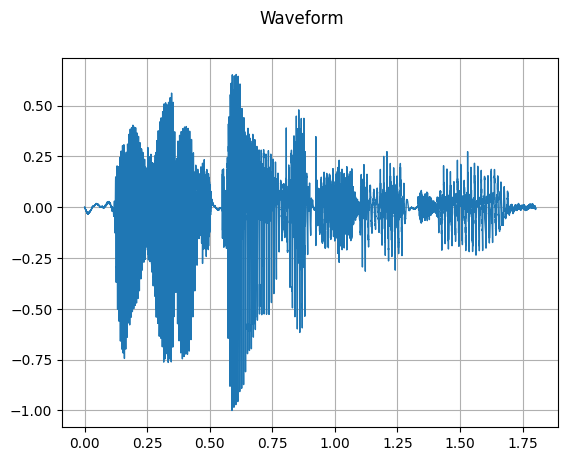

In [7]:
# Let's visualize the audio waveform using the plot_waveform function.

# plot_waveform function takes two inputs - the 'audio' waveform and the 'target_sampling_rate'.
# It plots the waveform using matplotlib to give us a glimpse of how the audio looks in its raw form.

# It's a simple yet powerful way to get an immediate feel of the audio's amplitude and fluctuations.

# Let's unleash the power of visualization and see the magic unfold!
plot_waveform(audio, target_sampling_rate)


The next piece of code is all about unraveling the secrets hidden in the audio's frequency domain! In just one line, we'll unleash the magic of the audio spectrogram.

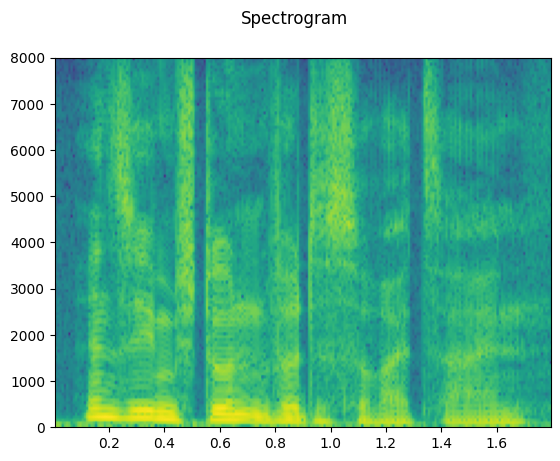

In [8]:
# Time to reveal the audio's spectral secrets with the plot_specgram function!

# plot_specgram function takes two inputs - the 'audio' waveform and the 'target_sampling_rate'.
# It uses matplotlib to create a visual representation of the audio's spectrogram.

# The spectrogram showcases how the audio's frequencies change over time, revealing patterns, rhythms, and harmonics.

# Get ready for an enchanting view of the audio's frequency composition! Let the spectral adventure begin!
plot_specgram(audio, target_sampling_rate)

In this code snippet, we're about to embark on the journey of extracting speaker embeddings using the "EcapaTDNN" model, creating an exciting AudioRepresentation object named audio_repr.

Once we have our AudioRepresentation ready, we'll utilize its power with the extract_embeddings function. This magical function takes an audio waveform as input and grants us the precious gift of speaker embeddings.

After the extraction, we're eager to peek at the filtered_encoder_response, as it holds the key to our speaker embeddings. And why stop there? We'll also check the shape of the filtered_encoder_response to see its dimensions.

Let's dive in and unravel the essence of our audio's identity!

In [9]:
# Create an AudioRepresentation object, audio_repr, using the "EcapaTDNN" model.
audio_repr = AudioRepresentation(model_name=audio_representation_name)

# The extract_embeddings function takes an input waveform and returns the corresponding speaker embeddings.
# It utilizes the audio_repr object to get the filtered_encoder_response for the input waveform.
# The raw_encoder_response contains the raw embeddings, while the filtered_encoder_response contains the refined ones.

# Let's witness the magic of audio embeddings unfolding before our eyes!
raw_encoder_response, filtered_encoder_response = audio_repr.contextual_encoding(audio)

# Print the filtered_encoder_response to see the precious speaker embeddings.
print(filtered_encoder_response)

# Let's also see the shape of the filtered_encoder_response to understand its dimensions.
print(filtered_encoder_response.shape)

tensor([[ 7.1968e-01,  1.0053e+01,  1.3620e+00, -1.2772e+01,  6.5594e+00,
          1.0310e+01, -3.5701e+00,  3.2551e+01,  7.7353e-01, -1.4245e+01,
          2.1048e+01, -6.3954e+00,  3.9364e+01,  1.4647e+01, -9.0067e+00,
         -9.4115e+00,  4.4901e+01, -1.4880e+01,  1.1169e-01,  1.4975e+01,
          1.6549e+01, -5.0775e+01, -5.0753e+01,  6.0484e+01, -1.3756e+01,
          3.2977e+01, -4.1445e+00,  9.0332e+00,  1.9168e+01, -1.2805e+00,
         -5.1555e+00,  1.0202e+01,  3.2785e+01,  5.8202e+01, -1.5340e+01,
         -1.1967e+01, -5.1124e+00, -1.2400e+01,  3.0613e+01, -1.4681e+01,
         -2.8424e-01,  9.9642e+00, -1.3461e+01, -4.4761e+00, -3.1261e+01,
          3.7153e+01, -4.6525e+00, -7.4152e+00, -1.0806e+01, -3.9094e+00,
         -1.6157e+01,  8.9765e+00, -5.7648e+00,  2.1441e+01, -2.7720e+01,
         -6.1816e+00,  7.3947e+00, -1.2282e+01,  3.0675e+00,  3.1331e+01,
         -1.9684e+01, -2.3344e+00,  4.0585e+01,  2.2562e+01, -1.9507e+01,
         -2.5820e+01, -2.5051e+01, -2.

Finally, we're going to perform temporal encoding using our trusty AudioRepresentation object named audio_repr.

With the temporal_encoding function, we're unleashing the power of temporal modeling to extract even more intriguing speaker embeddings from our audio waveform.

After the temporal encoding, we're excited to inspect the filtered_encoder_response, as it holds the precious speaker embeddings that capture the temporal dynamics.

Let's dive in and witness the wonder of temporal encoding and unveil the essence of our audio's identity through time!

In [10]:
# Perform temporal encoding using the audio_repr object to obtain speaker embeddings.
raw_encoder_response, filtered_encoder_response = audio_repr.temporal_encoding(audio)

# Print the filtered_encoder_response to see the precious speaker embeddings.
print(filtered_encoder_response)

# Let's also see the shape of the filtered_encoder_response to understand its dimensions.
print(filtered_encoder_response.shape)

tensor([[[ 0.4450, -0.1387, -0.1387,  ..., -0.1387, -0.1387, -0.1387],
         [ 0.0114,  0.0207,  0.0331,  ...,  0.0237,  0.0217,  0.0216],
         [ 0.1421,  0.0584,  0.0522,  ...,  0.0200,  0.0018,  0.0495],
         ...,
         [ 0.0274,  0.0040,  0.0140,  ...,  0.0124, -0.0113,  0.0074],
         [ 0.0575,  0.0246,  0.0277,  ...,  0.0618,  0.0567,  0.0694],
         [ 0.0660,  0.0387,  0.0456,  ...,  0.0467,  0.0302,  0.0445]]])
torch.Size([1, 3072, 181])


## That's all, folks!